In [2]:
import tensorflow as tf
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from random import sample
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
window_length = 10
encoding_dim = 3
epochs = 100
path = "/content/drive/MyDrive/Colab Notebooks/nasdaq2007_17.csv"

In [6]:
# Δημιουργία dataframe διαβάζοντας τo csv που δόθηκε.
# Τοποθετήστε το δικό σας path 

df = pd.read_csv(path, '\t', header=None)

In [7]:
df = df.transpose()
new_header = df.iloc[0] 
df = df[1:]
df.columns = new_header
# df

In [8]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size

In [9]:
scaler = MinMaxScaler()
# x_train_nonscaled = np.array([df.iloc[:,0:1].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df.iloc[:,0:1])))])
x_train_scaled = np.array([scaler.fit_transform(df.iloc[:,0:1].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df.iloc[:,0:1])))])

x_train = x_train_scaled[:-test_size]
x_test = x_train_scaled[-test_size:]

for j in range(1, len(df.columns) ):
    # x_train_nonscaled = np.array([df.iloc[:,j:j+1].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df.iloc[:,j:j+1])))])
    x_train_scaled = np.array([scaler.fit_transform(df.iloc[:,j:j+1].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df.iloc[:,j:j+1])))])

    x_train = np.append(x_train, x_train_scaled[:-test_size], axis=0)
    x_test = np.append(x_test, x_train_scaled[-test_size:], axis=0)

100%|██████████| 3639/3639 [00:01<00:00, 2123.34it/s]


In [10]:

def plot_examples(stock_input, stock_decoded):
    val = int(test_size/10)
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_size, val))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [11]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [12]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer
x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 10, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 1)              49        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 1)             0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 1)              4   

In [13]:
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
1020/1020 [==============================] - 22s 8ms/step - loss: 0.5663 - val_loss: 0.5296
Epoch 2/100
1020/1020 [==============================] - 8s 8ms/step - loss: 0.5287 - val_loss: 0.5268
Epoch 3/100
1020/1020 [==============================] - 8s 8ms/step - loss: 0.5274 - val_loss: 0.5263
Epoch 4/100
1020/1020 [==============================] - 8s 8ms/step - loss: 0.5271 - val_loss: 0.5260
Epoch 5/100
1020/1020 [==============================] - 8s 8ms/step - loss: 0.5268 - val_loss: 0.5258
Epoch 6/100
1020/1020 [==============================] - 8s 8ms/step - loss: 0.5267 - val_loss: 0.5257
Epoch 7/100
1020/1020 [==============================] - 8s 8ms/step - loss: 0.5265 - val_loss: 0.5256
Epoch 8/100
1020/1020 [==============================] - 8s 8ms/step - loss: 0.5264 - val_loss: 0.5255
Epoch 9/100
1020/1020 [==============================] - 8s 8ms/step - loss: 0.5263 - val_loss: 0.5253
Epoch 10/100
1020/1020 [==============================] - 8s 8ms/step - 

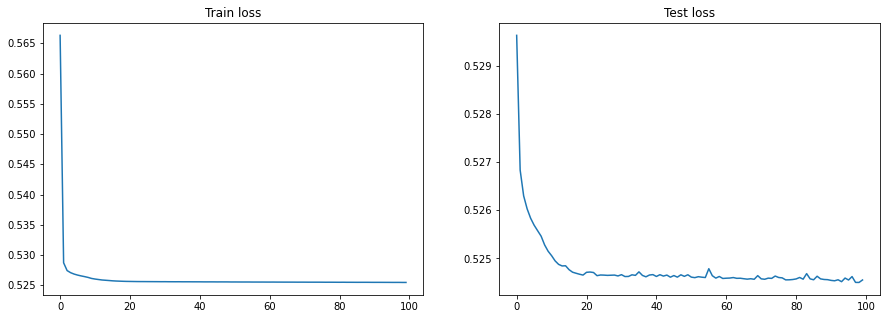

In [14]:
plot_history(history)

In [19]:
path ='myModel_c'
autoencoder.save(path)

INFO:tensorflow:Assets written to: myModel_c/assets


In [15]:
decoded_stocks = autoencoder.predict(x_test)

100%|██████████| 3639/3639 [00:01<00:00, 1873.93it/s]


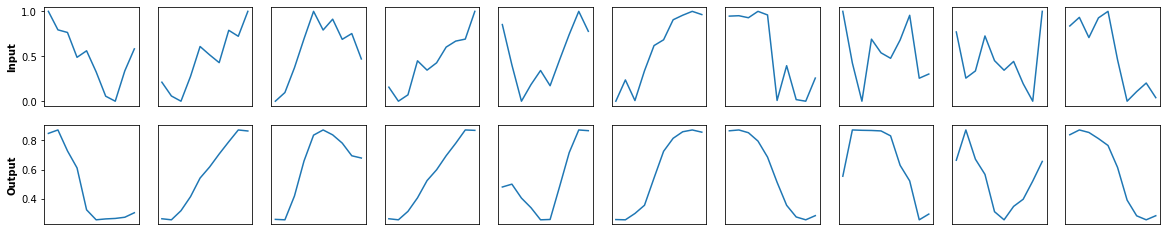

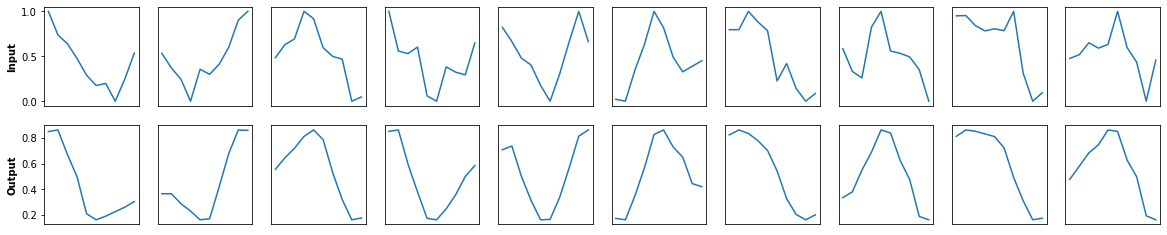

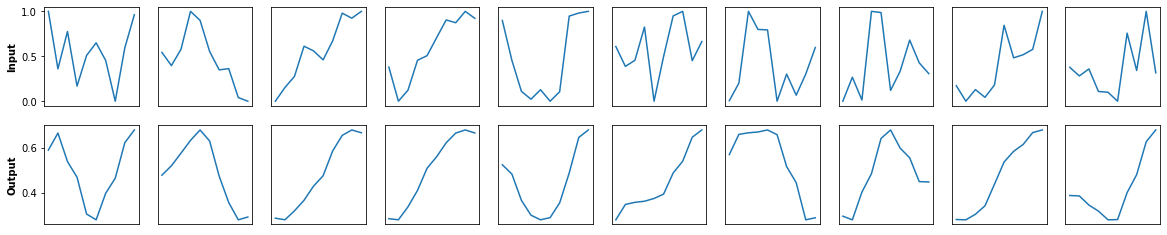

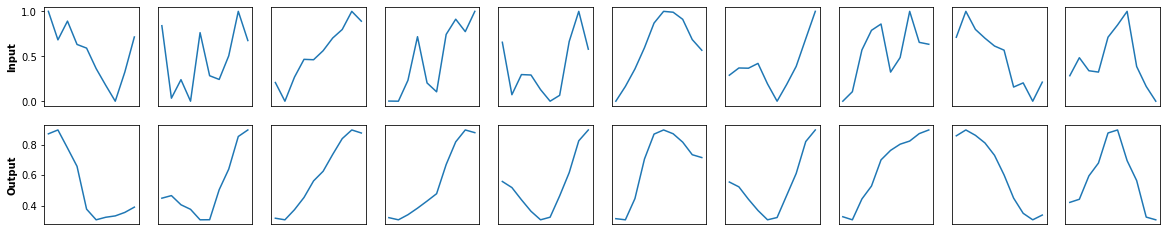

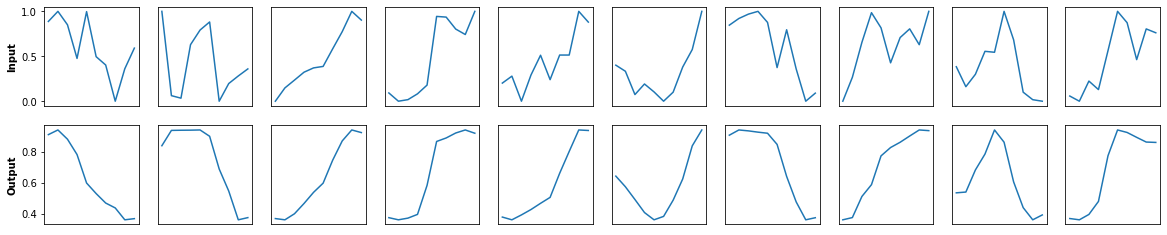

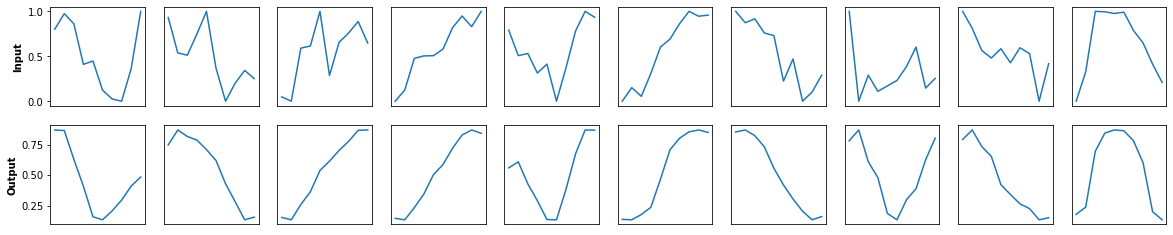

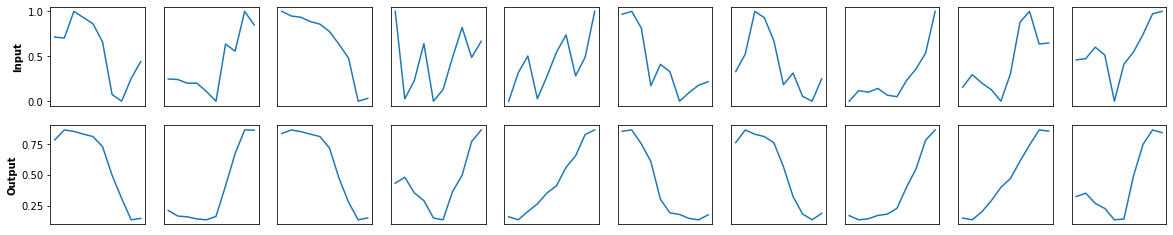

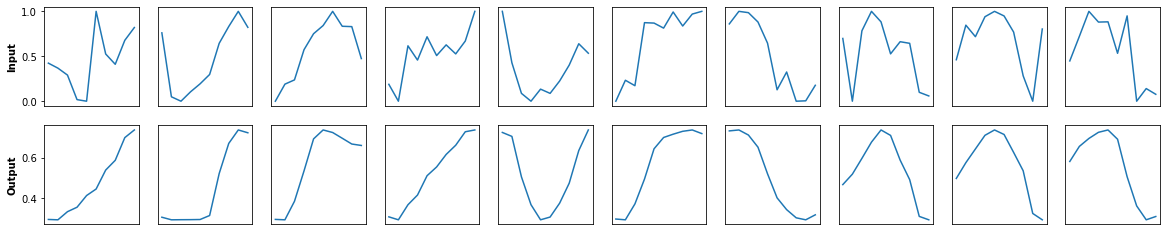

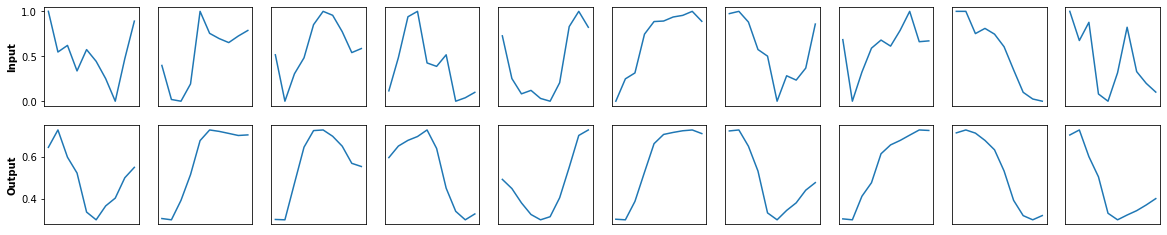

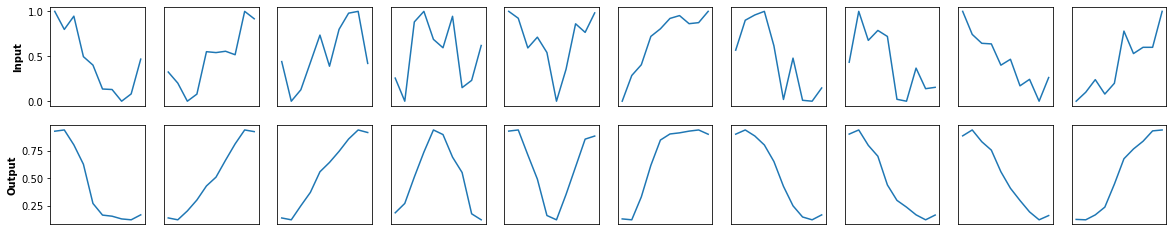

In [16]:
n = 10
for j in range(0, n):
    
    dataset_train = df.iloc[:train_size, j:j+1]
    dataset_test = df.iloc[train_size:, j:j+1]
    dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

    # x_train_nonscaled = np.array([df.iloc[:,j:j+1].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df.iloc[:,j:j+1])))])
    x_train_scaled = np.array([scaler.fit_transform(df.iloc[:,j:j+1].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df.iloc[:,j:j+1])))])

    x_train = x_train_scaled[:-test_size]
    x_test = x_train_scaled[-test_size:]

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    decoded_stocks = encoder.predict(x_test)
    
    plot_examples(x_test_deep, decoded_stocks)

In [ ]:
endecoded_stocks = encoder.predict(x_test)
endecoded_stocks = np.reshape(endecoded_stocks, (endecoded_stocks.size,1) )
endecoded_stocks = scaler.inverse_transform(endecoded_stocks)
endecoded_stocks= np.reshape(endecoded_stocks, (endecoded_stocks.size/10 ,10) )

In [ ]:
df = pd.DataFrame(endecoded_stocks)
df = df.transpose()
df.to_csv('output.csv', sep ='\t')